# **Lab 5b: Improving Land Cover Classification Using Optical and SAR Imagery**

## Introduction
This lab will use a random forest classifier to classify optical (Sentinel-2) and SAR (ALOS PALSAR ScanSAR HV polarization) images. The goal is to improve land cover classification by combining optical and SAR imagery.
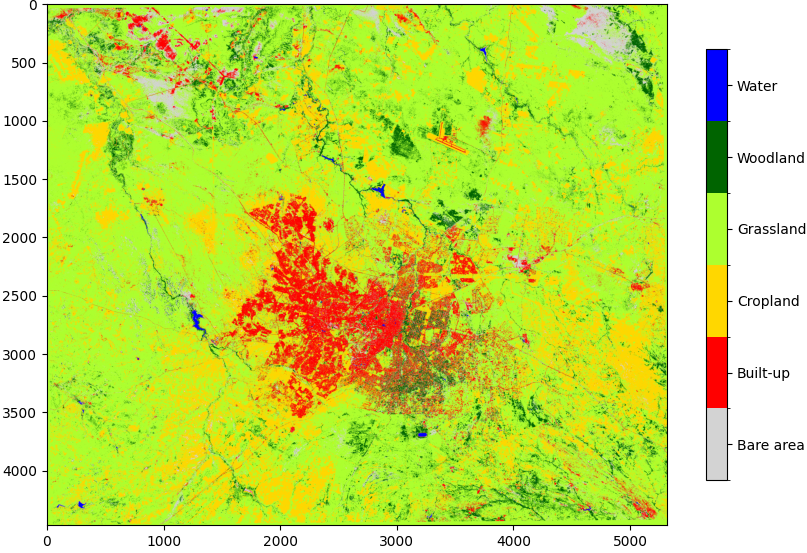



## Integrating optical and sythetic aperture radar (SAR)
PALSAR-2 ScanSAR is an observation mode of the Phased Array L-band Synthetic Aperture Radar-2 (PALSAR-2) onboard the ALOS-2 satellite, designed by the Japan Aerospace Exploration Agency (JAXA))for wide-area environmental monitoring. The 25 m PALSAR-2 ScanSAR (Google Earth Engine catalog) is normalized backscatter data of PALSAR-2 broad area observation mode with observation width of 350 km. Operating in the L-band frequency, it penetrates cloud and weather disturbances, enabling consistent, all-weather imaging. The radar employs Active Phased Array Antenna (APAA) technology for high-resolution, efficient data capture. The system provides a 14-day revisit time and near-global coverage, with data available monthly in 10-day intervals.

## Imports and Setup
### Install libraries
First, install any additional libraries that are not installed by default (e.g., rasterio, earthpy)..

In [ ]:
# Install rasterio and earthpy libraries
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00


### Import libraries
Import the necessary libraries (pandas, numpy, scikit-learn, rasterio, etc.).

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import seaborn as sns
import joblib

### Mount Google Drive
Next, mount your Google Drive. You will be prompted to authorize access to your Google Drive. Once mounted, you can read/write files in /content/drive/MyDrive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define paths and variables
Define the the paths to access your own directory structure in Google Drive. In this tutorial, we use:
-A CSV training dataset (Bul_TrainingData_2024.csv) containing pixel values and their corresponding classes.
- A multiband Sentinel-2 image (Bul_S2_2024.tif).
- PALSAR ScanSAR polarization

In [ ]:
# Define path that contains the datasets
Sample_Path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_TA_S2_Pal_2024.csv'
S2_Image_Path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_S2_2024.tif'
Palsar_Image_Path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_Palsar_HV_2024.tif'

### Define target and predictor variables
Next, define and specify the overall structure of the land cover classification task. Bands lists the Sentinel-2 spectral bands (e.g., B2, B3, B4) used as input features (predictors) for the model, while LC indicates the target column named “class.” Classes is a list of integer codes that the model will learn to predict, and N_Classes denotes the total number of these categories. The Names list provides descriptive labels (e.g., “Bare area,” “Built-up”) that match each code, making it easier to interpret results. Finally, Palette is a set of hex color codes for visualizing each class in plots or exported maps.

In [ ]:
# Define target and predictor variables
Bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'HV']  # Feature columns
LC = ['class']

Classes = [0, 1, 2, 3, 4, 5]
N_Classes = 6
Names   = ["Bare area", "Built-up", "Cropland", "Grassland", "Woodland", "Water"]
Palette = [
    '#D3D3D3',  # grey for class 0 (Bare area)
    '#FF0000',  # red for class 1 (Built-up)
    '#FFD700',  # gold for class 2 (Cropland)
    '#ADFF2F',  # greenyellow for class 3 (Grassland)
    '#006400',  # darkgreen for class 4 (Woodland)
    '#0000FF'   # blue for class 5 (Water)
]

## Load Images
We will use rasterio to open the .tif file. These are Sentinel-2 imagery and ALOS PALSAR ScanSAR HV polarization.

In [ ]:
# Load Sentinel-2 image
with rasterio.open(S2_Image_Path) as src_s2:
    s2_array = src_s2.read()  # shape: [bands, height, width]
    profile = src_s2.profile
    height, width = src_s2.height, src_s2.width

# Load PALSAR HV image
with rasterio.open(Palsar_Image_Path) as src_palsar:
    palsar_array = src_palsar.read(1)  # HV is single-band: [height, width]

# Ensure shapes match
assert s2_array.shape[1:] == palsar_array.shape, "Image sizes don't match. Reproject or resample needed."

### Display images
Display the Sentinel-2 composite and the PALSAR ScanSAR HV polorization image.

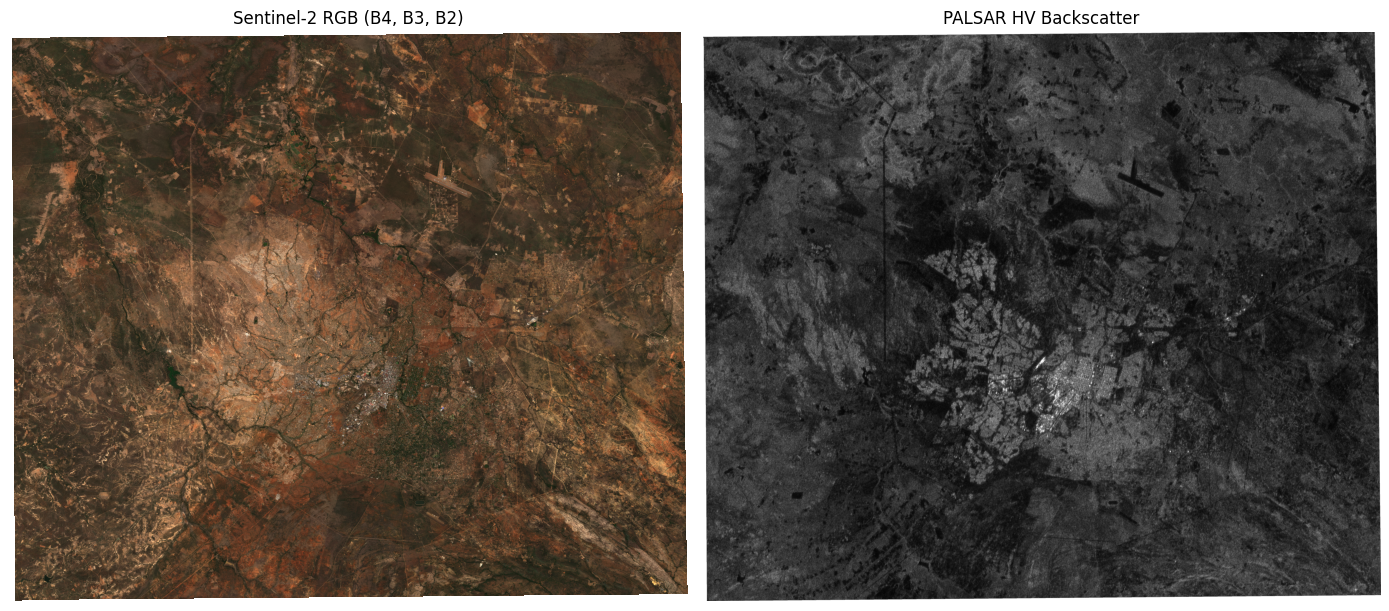

In [ ]:
# Select bands for RGB composite: B4 (Red), B3 (Green), B2 (Blue)
# Note: Check your band ordering if uncertain
red = s2_array[2, :, :]  # B4
green = s2_array[1, :, :]  # B3
blue = s2_array[0, :, :]  # B2

# Stack and normalize for RGB display
rgb = np.stack([red, green, blue], axis=-1)
rgb_min, rgb_max = 0, 0.3  # Adjust depending on your scaling
rgb_display = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)

# Normalized HV (grayscale display)
hv_min, hv_max = 0,1
hv_display = np.clip((palsar_array - hv_min) / (hv_max - hv_min), 0, 1)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].imshow(rgb_display)
axs[0].set_title('Sentinel-2 RGB (B4, B3, B2)')
axs[0].axis('off')

axs[1].imshow(hv_display, cmap='gray')
axs[1].set_title('PALSAR HV Backscatter')
axs[1].axis('off')

plt.tight_layout()
plt.show()

##  Load and Prepare Training Data
Next, load and prepare the training data. The training data is in a CSV format with columns for each band (B2, B3, etc.) and a class column (land cover type).

In [ ]:
# Load training data as a DataFrame
df = pd.read_csv(Sample_Path)

# Inspect first few rows
print(df.head())

# Separate features (X) and label (y)
X = df[Bands]
y = df['class']

# Ensure no missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in label: {y.isnull().sum()}")

# Split into training and testing subsets
# (you can also do cross-validation if you prefer)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

   system:index      B11      B12      B2       B3       B4      B5      B6  \
0             0  0.18410  0.13230  0.0379  0.04790  0.05980  0.0883  0.1197   
1             1  0.26330  0.19170  0.0490  0.06770  0.08980  0.1253  0.1636   
2             2  0.15300  0.10990  0.0322  0.04770  0.04680  0.0795  0.1322   
3             3  0.43365  0.38825  0.1145  0.16795  0.22625  0.2572  0.2794   
4             4  0.38520  0.33210  0.0947  0.12220  0.16200  0.1874  0.1994   

       B7      B8        HV  class                                    .geo  
0  0.1346  0.1416  0.322125      0  {"type":"MultiPoint","coordinates":[]}  
1  0.1854  0.1985  0.343250      0  {"type":"MultiPoint","coordinates":[]}  
2  0.1466  0.1577  0.316500      0  {"type":"MultiPoint","coordinates":[]}  
3  0.2934  0.2926  0.206125      0  {"type":"MultiPoint","coordinates":[]}  
4  0.2170  0.2266  0.150375      0  {"type":"MultiPoint","coordinates":[]}  
Missing values in features: 0
Missing values in label: 0
Traini

## Train and Evaluate Multiple Classifiers

We will train four classifiers: K-nearest neighbors (KNN), support vector machine (SVM), decision tree, and random forest. Then we will compare their performance using accuracy, confusion matrices, and classification reports.

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

### Model validation
We will compare their performance using accuracy, confusion matrices, and classification reports.


** Random Forest **
Accuracy: 0.859162235767086
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       520
           1       0.87      0.86      0.87       792
           2       0.89      0.92      0.90      3000
           3       0.84      0.85      0.84      2849
           4       0.78      0.77      0.77       464
           5       0.96      0.93      0.95        86

    accuracy                           0.86      7711
   macro avg       0.86      0.83      0.84      7711
weighted avg       0.86      0.86      0.86      7711



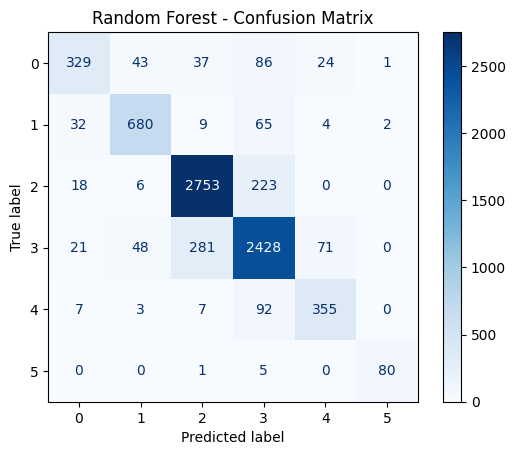

In [ ]:
# Evaluate each model
models = {
    "Random Forest": rf_preds
}

for name, preds in models.items():
    print(f"\n** {name} **")
    print("Accuracy:", (preds == y_test).mean())

    # Classification Report
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds, labels=Classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Classes)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

## Save the Best RF Model
Let's save the best RF model parameters, feature names, or other metadata together.


In [ ]:
# Save the best model parameters
model_package = {
    "model": rf,            # your trained Random Forest model
    "features": Bands,      # input feature names
    "label": 'class'        # label column name
}

# Define model path
MODEL_PATH = '/content/drive/MyDrive/Bulawayo_Dataset_2024/best_rf_model.pkl'
joblib.dump(model_package, MODEL_PATH)
print("Model saved successfully.")

Model saved successfully.


## Land Cover Classification

Choose one or more of the trained classifiers (e.g., Random Forest for demonstration) to predict class labels for every pixel of the Sentinel-2 image.

### i. Stack Sentinel-2 and PALSAR HV images

In [ ]:
# Stack PALSAR HV as an extra band ---
palsar_array_expanded = palsar_array[np.newaxis, :, :]  # shape: [1, height, width]
combined_array = np.concatenate((s2_array, palsar_array_expanded), axis=0)  # shape: [bands+1, height, width]
print("Combined array shape:", combined_array.shape)

Combined array shape: (10, 4469, 5317)


### ii. Reshape for prediction
Scikit-Learn expects a 2D array for prediction, where each row corresponds to a pixel and each column corresponds to a band. Therefore, we need to reshape from (bands, height, width) to (height*width, bands) for input into Scikit-Learn.

In [ ]:
# Reshape for classification ---
band_count = combined_array.shape[0]
img_reshaped = combined_array.reshape(band_count, -1).T  # shape: [n_pixels, n_features]
print("Reshaped array for prediction:", img_reshaped.shape)

Reshaped array for prediction: (23761673, 10)


### iii.  Use the random forest for prediction
Next, we will use the random forest for prediction. Finally, we will take a 1D array of predicted land cover classes and reshape it back into a 2D raster format (image) so it matches the original image's spatial dimensions.

In [ ]:
# Predict using trained RandomForest model (e.g. rf) ---
prediction = rf.predict(img_reshaped)
prediction = prediction.astype(np.uint8)

# Reshape back to image
prediction_map = prediction.reshape(height, width)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Visualize the land cover map

Next, visualize the resulting map with a color palette corresponding to each class ID.

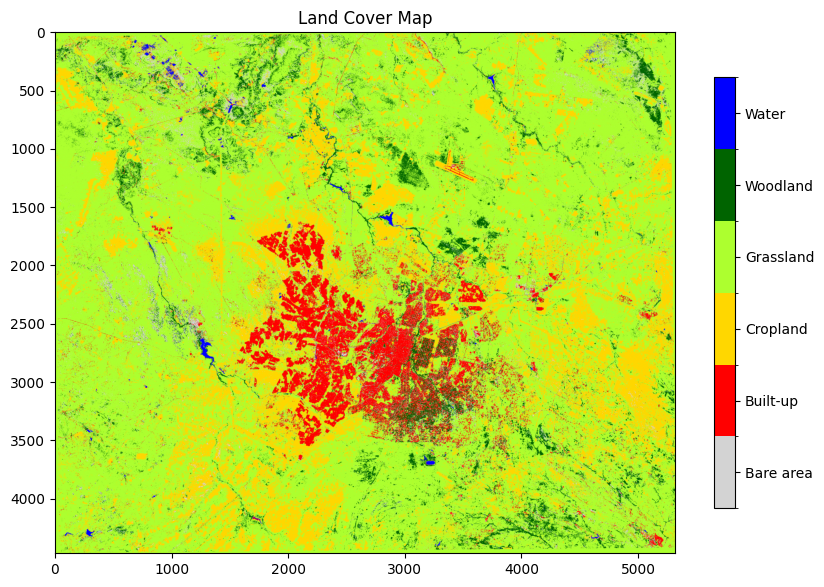

In [ ]:
# Prepare a discrete colormap
# We need one more level than classes for from_levels_and_colors
levels = Classes + [max(Classes) + 1]
cmap, norm = from_levels_and_colors(levels, Palette)

plt.figure(figsize=(10,8))
im = plt.imshow(prediction_map, cmap=cmap, norm=norm)
plt.title("Land Cover Map")

# Create colorbar with a shrink factor (0.7 = 70% of default height)
cbar = plt.colorbar(im, shrink=0.7)

# Center tick labels
tick_positions = [i + 0.5 for i in Classes]
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(Names)

plt.show()

## Export the Land Cover Map
We can save the land cover map to a new GeoTIFF using rasterio.

In [ ]:
# Save predicted land cover map
output_path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_LC_RF_2024b.tif'
with rasterio.open(
    output_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=np.uint8,
    crs=profile['crs'],
    transform=profile['transform']
) as dst:
    dst.write(prediction_map, 1)